# mom6_bathy Notebook Gallery
## Spherical grid with equatorial refinement

In this notebook, we create a spherical grid with uniform resolution. We then increase the resolution around the equator by a factor of two by providing new, custom x and y coordinates array for the supergrid.

## 1. Import Modules

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from mom6_bathy.mom6grid import mom6grid
from mom6_bathy.mom6bathy import mom6bathy

## 2. Create a horizontal MOM6 grid

Spherical grid. x coordinates interval= [0, 360] degrees. y coordinates interval = [-80,+80] degrees

In [2]:
# Instantiate a MOM6 grid instance
grd = mom6grid(
        nx         = 180,         # Number of grid points in x direction
        ny         = 80,          # Number of grid points in y direction
        config     = "spherical", # Grid configuration. Valid values: 'cartesian', 'mercator', 'spherical'
        axis_units = "degrees",   # Grid axis units. Valid values: 'degrees', 'm', 'km'
        lenx       = 360.0,       # grid length in x direction, e.g., 360.0 (degrees)
        leny       = 160,         # grid length in y direction
        cyclic_x   = "True",      # reentrant, spherical domain
        ystart     = -80          # start/end 10 degrees above/below poles to avoid singularity 
)

Updating supergrid...


### Plot grid properties:

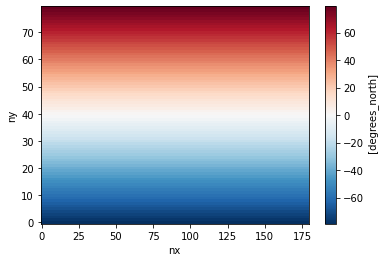

In [3]:
grd.tlat.plot();

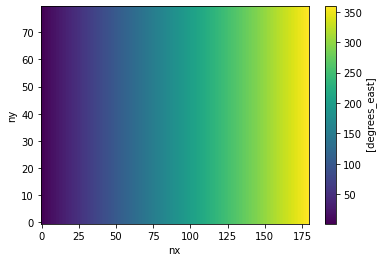

In [4]:
grd.tlon.plot();

### *Customize the grid resolution around the equator*
To do so, we provide new x and y coordinate arrays for the supergrid

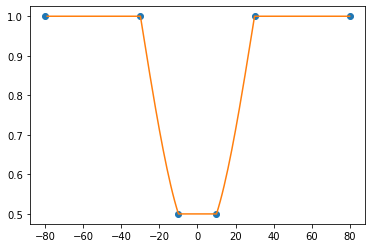

In [5]:
# First, define a refinement function along longitutes:
from scipy import interpolate
f = 0.5
r_y = [-80,-30,-10,10,30,80] # transition latitudes
r_f = [1,1,f,f,1,1]          # inverse refinement factors at transition latitudes
interp_func = interpolate.interp1d(r_y, r_f, kind=3)
r_f_mapped = interp_func(grd.supergrid.y[1:,0])
r_f_mapped = np.where(r_f_mapped < 1.0, r_f_mapped, 1.0)
r_f_mapped = np.where(r_f_mapped > f, r_f_mapped, f)
plt.plot(r_y, r_f, 'o', grd.supergrid.y[1:,0], r_f_mapped, '-');

Now apply the above refinement function (`r_f_mapped`) to the y coordinates of the original supergrid:

In [6]:
super_dy = grd.supergrid.y[1:,0] - grd.supergrid.y[:-1,0]
super_dy_new = super_dy.mean() * r_f_mapped / r_f_mapped.mean() # normalize
super_y_new = grd.supergrid.y[:,0].copy()
super_y_new[1:] = grd.supergrid.y[0,0] + super_dy_new.cumsum()
xdat, ydat = np.meshgrid(grd.supergrid.x[0,:], super_y_new)

Update the supergrid:

In [7]:
grd.update_supergrid(xdat, ydat)

Updating supergrid...


Confirm that the equatorial resolution is increased by a factor of two:

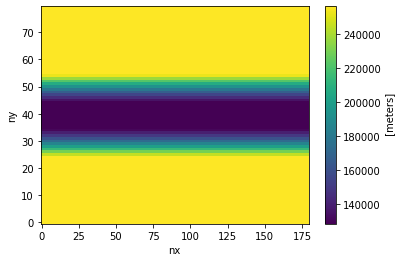

In [8]:
grd.dyt.plot()

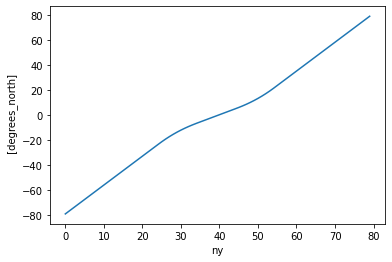

In [9]:
grd.tlat.isel(nx=0).plot()

## 3. Configure the bathymetry

In [10]:
# Instantiate a mom6bathy object associated with the horizontal grid object (grd).
bathy = mom6bathy(grd, min_depth=10.0)

### *flat bottom bathymetry*

In [11]:
# Set the bathymetry to be a flat bottom with a depth of 2000m
bathy.set_flat(D=2000.0)

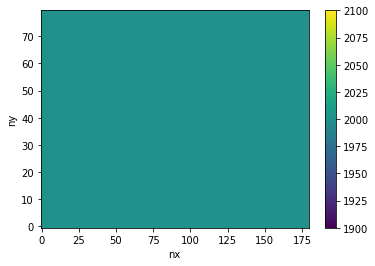

In [12]:
bathy.depth.plot()

## 4. Save the grid and bathymetry files

In [13]:
# supergrid file:
grd.to_netcdf(supergrid_path="./ocean_hgrid_speq.nc")

# ocean_topog:
bathy.to_topog("./ocean_topog_speq.nc")

# ESMF mesh file:
bathy.to_ESMF_mesh("./ESMF_mesh_speq.nc")

## 5. Print MOM6 runtime parameters

The final step of creating a new MOM6 grid and bathymetry files is to determine the relevant MOM6 runtime parameters. To do so, simply run the `print_MOM6_runtime_params` method of `bathy` to print out the grid and bathymetry related MOM6 runtime parameters.

In [14]:
bathy.print_MOM6_runtime_params()

INPUTDIR = "./INPUT/"
TRIPOLAR_N = False
NIGLOBAL = 180
NJGLOBAL = 80
GRID_CONFIG = "mosaic"
TOPO_CONFIG = "file"
MAXIMUM_DEPTH = 2000.0
MINIMUM_DEPTH = 10.0
REENTRANT_X = True
GRID_FILE = ???
TOPO_FILE = ???


The above parameter settings are to be added to user_nl_mom (or MOM_override) file when a new CESM experiment is created.

----------------

**NOTE**: This is the final step that requires `mom6_bathy`. The remaining steps should be carried out in a terminal.

### 6. Add the new grid to CESM

Once all the input files are generated, we are ready to define the grid and resolution within CESM. The first step is to determine a name and an alias for this newly created grid. For this example, we name our grid `simple2v1` and choose to abbreviate it as `s2v1`. To add this new grid in CESM, we modify the following xml file which includes all the grid definitions for the NUOPC interface:

  ```CESM/ccs_config/component_grids_nuopc.xml```

In the above XML file, we add the following XML entry. (NOTE: make sure to update the mesh path below so it points to the ESMF mesh file that you have created in the previous step):

```
  <domain name="simple2v1">
    <nx>180</nx> <ny>90</ny>
    <mesh>/glade/u/home/altuntas/mom6_bathy/notebooks/ESMF_mesh_speq.nc</mesh>
    <desc>A simple mesh generated with mom6_bathy</desc>
    <support>Experimental for MOM6 experiments</support>
  </domain>
```

After having defined the grid, we are ready to define a resolution, which is a collection of component grids to be specified when a CESM case gets created. Similar to how a new grid gets added, a new resolution can be added in the following XML file:

  ```CESM/ccs_config/modelgrid_aliases_nuopc.xml```
  
In the above file, we add the following new resolution:

```
  <model_grid alias="T62_s2v1" not_compset="_CAM">
    <grid name="atm">T62</grid>
    <grid name="lnd">T62</grid>
    <grid name="ocnice">simple2v1</grid>
  </model_grid>
```

Notice that we choose the readily available `T62` grid as our atmosphere grid, but users can also choose to create and specify a new atmosphere/land grid or choose another existing grid. 

After having defined the new ocean grid `simple2v1` and the new resolution `T62_s2v1`, we are ready to create a new case and utilize this new grid. To do so, simply specify the `--res T62_s2v1` argument when running the `create_newcase` command.


### 7. Create a new case

To create a CESM experiment with the newly created grid, make sure to run the `create_newcase` command with the `--run-unsupported` flag. For example:

```CESM/cime/scripts/create_newcase --run-unsupported --compset 2000_DATM%NYF_SLND_SICE_MOM6_SROF_SGLC_SWAV --res T62_s2v1 --case foo.001```


After having run the `create_newcase` command, cd into the case directory. Since this is a brand new experiment configuration, make sure that all components have enough cores allocated. If not, make sure to update `NTASKS`, e.g., as follows:

```
./xmlchange NTASKS=72
./xmlchange NTASKS_OCN=108
```

You can then run `./case.setup` and `./case.build` commands, respectively. 

#### *Copy grid input files*

Create an `INPUT` directory inside your run directory. You can find out the run directory by running `./xmlquery RUNDIR` command. After having created the `INPUT` directory, copy (or symbolically link) the MOM6 supergrid and topography files inside the `INPUT` directory.

### 8. Configure MOM6

#### *Grid-specific runtime parameters*

Add the grid-specific runtime parameter values to `user_nl_mom`. Recall that these are:

In [15]:
bathy.print_MOM6_runtime_params()

INPUTDIR = "./INPUT/"
TRIPOLAR_N = False
NIGLOBAL = 180
NJGLOBAL = 80
GRID_CONFIG = "mosaic"
TOPO_CONFIG = "file"
MAXIMUM_DEPTH = 2000.0
MINIMUM_DEPTH = 10.0
REENTRANT_X = True
GRID_FILE = ???
TOPO_FILE = ???


---
NOTE: Replace `???` values above with the supergrid and topography file paths that were created in the previous steps. The paths should be relative to the `INPUT` directory inside the run directory. For example:

```
GRID_FILE = "./ocean_hgrid_speq.nc"
TOPO_FILE = "./ocean_topog_speq.nc"
```

#### *Timestep*

MOM6 has the following timesteps: the barotropic timestep, the baroclinic (momentum dynamics) timestep, the tracer timestep, and the remapping interval. At a minimum, the baroclinic timestep must be specified for a custom grid in `user_nl_mom`. Make sure that the timestep is small enough to satisfy the CFL condition. For example:

```
DT = 1800
    ! Baroclinic Timestep
```

#### *Vertical grid*

In the `user_nl_mom` file, set the following vertical grid parameters (and others depending on the desired configuration.) We provide a very simple vertical grid configuration below.
```
NK = 20
    ! The number of model layers.
COORD_CONFIG = "none"   
    ! This specifies how layers are to be defined:
    ! none is used to avoid defining layers in ALE mode
REGRIDDING_COORDINATE_MODE = "Z*"
    ! Coordinate mode for vertical regridding.
    ! Z* - stretched geopotential z*
ALE_COORDINATE_CONFIG = "UNIFORM"
    ! Determines how to specify the coordinate resolution.
    !  UNIFORM[:N] - uniformly distributed
```

#### *Initial Conditions*

Configure the initial conditions (IC) by adding IC-specific runtime parameters to `user_nl_mom`. For this simple model, we choose to adopt an idealized initial conditions (temperature and salinity) predefined in MOM6 internally. To do so, we set the following MOM6 runtime parameters:
```
TS_CONFIG = "fit"
    ! find the temps consistent with the layer densities and S_REF.
T_REF = 5.0
    ! A reference temperature used in initialization.
FIT_SALINITY = True
    ! If true, accept the prescribed temperature and fit the salinity
```